<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/6_Duolingo_q1lpipe1_MLsplitting_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color='cornflowerblue' size=4>Introduction</font>

Featureset1 for addressing Q1 (what makes a word easy or difficult to remember)with word based features has been preprocessed and converted to a compressed sparse array for modeling.

The training set contains around 8 million records with 16% records with forgotten words. Since the dataset is imbalanced, and the dataset is large enough, some downsampling will be done.

Plan:

1. Split datasets into training and validation with 80-20. 
2. Downsample training set to equal class proportions.

Classical ML models: understanding overall feature importances.
Prep: from the downsampled training set, select at most 1 million records, and fit the following models

1. Logistic Regression (L2 penalty, vary C and class weight)
2. Decision Tree (vary max_depth, class_weight)


Ensemble techniques:
Prep: Use the full downsampled dataset
1. Random Forest (vary n_estimators, )
2. XGBoost
3. AdaBoost

Neural Net (keras)
1. Dense architecture
2


## <font color = 'cornflowerblue' size=4>Splitting trainingset into train and validation sets</font>

Importing libraries, mounting google drive, and getting Q1TRAIN pipe1 set. 

In [1]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Mounted at /content/drive


In [2]:
q1trainXsp = decompress_pickle(path_name+"q1train_pipe1.pbz2") 

In [3]:
q1trainXsp.shape, q1trainXsp.size/10**6

((8070561, 170), 86.851987)

In [4]:
q1train_y = decompress_pickle(path_name+"q1train_y.pbz2") 

In [5]:
type(q1trainXsp), type(q1train_y)

(scipy.sparse.coo.coo_matrix, pandas.core.series.Series)

In [ ]:
from scipy.sparse import coo_matrix

## Splitting into training and validation sets 90-10

splitting into 80-20 training and validation set with a random state = 5. (had to remove stratify argument, because it doesn't work for sparse arrays)

In [6]:
from sklearn.model_selection import train_test_split

Xq1_train, Xq1_valid, yq1_train, yq1_valid = train_test_split(q1trainXsp,q1train_y,test_size=0.1,random_state=5)

In [7]:
Xq1_train.shape, Xq1_valid.shape, yq1_train.shape, yq1_valid.shape

((7263504, 170), (807057, 170), (7263504,), (807057,))

Fraction of ones in the train and validation sets

In [8]:
yq1_train.sum()/yq1_train.shape[0], yq1_valid.sum()/yq1_valid.shape[0]

(0.16344962431355445, 0.1641990590503521)

## <font color = 'cornflowerblue' size=4>Classical models:

The training set is now downsampled and reduced to 1 milion records for a quick run of classical models to see what the most important features are. 

### <font color = 'cornflowerblue' size=3>Downsampling training dataset</font>

In [9]:
# creating sparse dataframe from sparse matrix
df = pd.DataFrame.sparse.from_spmatrix(Xq1_train)
# combining with y
df['y'] = yq1_train

# nsplitting sparse dataframe by class values
df0 = df[df['y']==0]
df1 = df[df['y']==1]

# number of positive samples
numdf1 = df1.shape[0]

# what fraction of df0 do we need to equal the numbers of df1?
fractiondf0 = numdf1/df0.shape[0]

# sampling from negative class samples to get only the fraction needed 
df0_ = df0.sample(frac = fractiondf0,random_state = 15)

# recombine and shuffle downsampled negative samples df0_ and all of positive samples df1:
df_downsampled = pd.concat([df0_, df1],axis=0).sample(frac=1,random_state=20)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


In [10]:
# create the sparse matrices ready for training
yq1_train_ds = df_downsampled['y']
Xq1_train_ds = df_downsampled.drop('y',axis=1)



In [11]:
Xq1_train_ds.shape, yq1_train_ds.shape, numdf1, df0_.shape, df1.shape, df0.shape, df.shape

((1338050, 170),
 (1338050,),
 669025,
 (669025, 171),
 (669025, 171),
 (3450813, 171),
 (7263504, 171))

In [12]:
yq1_train_ds.sum()/yq1_train_ds.shape[0]

0.5

Since there are around 1.33 million records in the downsampled dataset, no more reduction is necessary. The number of positive and negative samples is equal. 

### <font color= 'cornflowerblue' size=3>Scaling downsampled dataset</font>

They are about the same, we will use this split to test a number of models. They are saved below:

First, we scale and transform the data using the min-max scaler. 

In [13]:
from sklearn.preprocessing import MaxAbsScaler # used because sparse array not supported by MinMaxScaler
mm_scaler = MaxAbsScaler()

mm_scaler.fit(Xq1_train_ds)
Xq1_mm_train_ds = mm_scaler.transform(Xq1_train_ds)
Xq1_mm_valid_ds = mm_scaler.transform(Xq1_valid) # downsampled scaler is applied. 


###<font color = 'cornflowerblue' size= 3>Logistic regression</font>

Hyperparamters:
1. C
2. class weights


In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_validate # return scores for many metrics

from sklearn.metrics import make_scorer # to define a list of scoring metrics to use

from sklearn.model_selection import GridSearchCV # to search hyperparameters in a grid 

classweight_vals = [{0:0.9,1:0.1},{0:0.01,1:0.99}]
C_vals = [10**(-3),1,10**3]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['C'] = C_vals


# iterate over 
logreg = LogisticRegression(solver = 'lbfgs',max_iter=50)
scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(logreg, n_jobs = 4, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=1,refit=False)

gridsearch_obj.fit(Xq1_mm_train,yq1_train_ds)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=50), n_jobs=4,
             param_grid={'C': [0.001, 1, 1000],
                         'class_weight': [{0: 0.9, 1: 0.1},
                                          {0: 0.01, 1: 0.99}]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=1)

In [ ]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_C','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_C,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,"{0: 0.9, 1: 0.1}",0.001,4.66,1.22,0.5,0.5,0.5,0.00,0.0
1,"{0: 0.01, 1: 0.99}",0.001,2.67,1.11,0.5,0.5,0.5,0.67,1.0
2,"{0: 0.9, 1: 0.1}",1,6.57,1.09,0.5,0.5,0.5,0.00,0.0
3,"{0: 0.01, 1: 0.99}",1,6.21,1.11,0.5,0.5,0.5,0.67,1.0
4,"{0: 0.9, 1: 0.1}",1000,6.52,1.10,0.5,0.5,0.5,0.00,0.0
5,"{0: 0.01, 1: 0.99}",1000,6.39,1.09,0.5,0.5,0.5,0.67,1.0


Changing C had no real impact on the accuracy, which is still at the baseline value. Recall is either 1 or 0, indicating that the models either predict all 1s or all 0s.

Logistic regression does not seem promising to train on the full dataset, nor is it likely at 0.5 accuracy to give any information of feature importance. 

Decision trees are tried next. 

### <font color='cornflowerblue' size=3>Decision Trees</font>

The downsampled dataset is trained on decision trees with varying class weight and max_depth.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()

classweight_vals = [{0:0.45,1:0.55},{0:0.55,1:0.45}]
maxdepth_vals = [5,30]

para_dict =dict()
para_dict['class_weight'] = classweight_vals
para_dict['max_depth'] = maxdepth_vals


scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=3,refit=False)

gridsearch_obj.fit(Xq1_mm_train,yq1_train_ds)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END class_weight={0: 0.45, 1: 0.55}, max_depth=5; accuracy: (test=0.500) average_precision: (test=0.500) f1: (test=0.667) recall: (test=1.000) roc_auc: (test=0.500) total time=   7.3s
[CV 2/3] END class_weight={0: 0.45, 1: 0.55}, max_depth=5; accuracy: (test=0.500) average_precision: (test=0.499) f1: (test=0.667) recall: (test=1.000) roc_auc: (test=0.499) total time=   7.1s
[CV 3/3] END class_weight={0: 0.45, 1: 0.55}, max_depth=5; accuracy: (test=0.500) average_precision: (test=0.500) f1: (test=0.666) recall: (test=0.999) roc_auc: (test=0.500) total time=   7.0s
[CV 1/3] END class_weight={0: 0.45, 1: 0.55}, max_depth=30; accuracy: (test=0.499) average_precision: (test=0.499) f1: (test=0.635) recall: (test=0.870) roc_auc: (test=0.499) total time= 2.5min
[CV 2/3] END class_weight={0: 0.45, 1: 0.55}, max_depth=30; accuracy: (test=0.501) average_precision: (test=0.500) f1: (test=0.649) recall: (test=0.925) roc_auc: (test

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [{0: 0.45, 1: 0.55},
                                          {0: 0.55, 1: 0.45}],
                         'max_depth': [5, 30]},
             refit=False,
             scoring=['accuracy', 'f1', 'average_precision', 'roc_auc',
                      'recall'],
             verbose=3)

In [ ]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_class_weight','param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_class_weight,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,"{0: 0.45, 1: 0.55}",5,6.08,1.05,0.5,0.5,0.5,0.67,1.0
1,"{0: 0.45, 1: 0.55}",30,115.32,1.28,0.5,0.5,0.5,0.64,0.9
2,"{0: 0.55, 1: 0.45}",5,6.04,1.04,0.5,0.5,0.5,0.00,0.0
3,"{0: 0.55, 1: 0.45}",30,117.30,1.26,0.5,0.5,0.5,0.17,0.1


In [ ]:
dtree = DecisionTreeClassifier(max_features=100)


maxdepth_vals = [6,10,15]

para_dict =dict()

para_dict['max_depth'] = maxdepth_vals


scoring_metrics = ['accuracy','f1','average_precision','roc_auc','recall']

gridsearch_obj = GridSearchCV(dtree, param_grid = para_dict,cv=3,scoring = scoring_metrics, verbose=3,refit=False)

gridsearch_obj.fit(Xq1_mm_train,yq1_train_ds)

NameError: ignored

In [ ]:
gridcv = pd.DataFrame(gridsearch_obj.cv_results_)
np.around(gridcv[['param_max_depth','mean_fit_time',  'mean_score_time', 
       'mean_test_accuracy','mean_test_average_precision','mean_test_roc_auc','mean_test_f1','mean_test_recall']],2)

,param_max_depth,mean_fit_time,mean_score_time,mean_test_accuracy,mean_test_average_precision,mean_test_roc_auc,mean_test_f1,mean_test_recall
0,6,4.25,1.09,0.5,0.5,0.5,0.52,0.60
1,10,7.66,1.13,0.5,0.5,0.5,0.45,0.41
2,15,14.17,1.15,0.5,0.5,0.5,0.44,0.42


No improvement in precision is obtained from varying max_depth. 

In [ ]:
coefficients['EnglishIDF'], coefficients['sf_length'],coefficients['L_dist_sf_noaccents_norm']

(-0.10264018301608246, -0.39245070230713114, 0.3866483915452818)

In [ ]:
coefficients.to_csv(path_name+"Logreg_L1_q1fulldataset_coefficients.csv")

Makes sense that lower history correct gives a greater chance of forgetting the word. 

In [ ]:
coefficients[coefficients<0.05].shape

Of the 2223 features, 2037 had non-zero coefficients. 

## <font color = 'cornflowerblue' size=4>Ensemble models</font>

## <font color = 'cornflowerblue' size=3>Random Forest</font>

### <font color = 'cornflowerblue' size = 3>XGBoost</font>

In [ ]:
from xgboost import XGBClassifier


XGB_model = XGBClassifier(num_feature = 60,subsample = 0.7)
XGB_model.fit(Xq1_mm_train, yq1_train_ds)
print(f"XG Boost train set score: {XGB_model.score(Xq1_mm_train, yq1_train_ds)}")
print(f"XG Boost test set score: {XGB_model.score(Xq1_mm_valid, yq1_valid)}")

XG Boost train set score: 0.5078464930309032
XG Boost test set score: 0.5039507742327989


In [ ]:
yq1_train_preds_probs_xgb = XGB_model.predict_proba(Xq1_mm_train)[:,1]
yq1_valid_preds_probs_xgb = XGB_model.predict_proba(Xq1_mm_valid)[:,1]


NameError: ignored

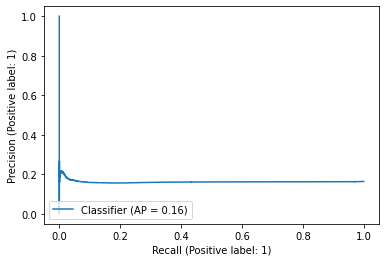

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(yq1_valid,yq1_valid_preds_probs_xgb)

In [ ]:
feature_names = decompress_pickle(path_name+"q1fs1_column_names.pbz2")
XGBfeature_importances = pd.Series(XGB_model.feature_importances_,index=feature_names)
XGBfeature_importances.sort_values(ascending=False).head(20)

mod_x0_sint      0.021982
mod_x0_*pers     0.021281
mod_x0_itg       0.020207
mod_x0_pp        0.020172
pos_x0_cnjcoo    0.019916
mod_x0_def       0.019458
mod_x0_obj       0.018834
lang_x0_en       0.018438
mod_x0_mf        0.018357
mod_x0_sp        0.017005
mod_x0_enc       0.016570
pos_x0_adv       0.015750
mod_x0_*numb     0.015594
pos_x0_cnjsub    0.015531
simoverdiff      0.015501
mod_x0_fti       0.015397
mod_x0_tn        0.015206
mod_x0_pro       0.015134
pos_x0_adj       0.015110
pos_x0_n         0.015038
dtype: float32

In [ ]:
XGBfeature_importances.to_csv(path_name+"XGB_feature_importances_q1_1.csv")

## AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
AB_model = AdaBoostClassifier(n_estimators=100, learning_rate=1)

AB_model.fit(Xq1_mm_train,yq1_train)
y_probaAB = AB_model.predict_proba(Xq1_mm_valid)[:,1]

In [ ]:
yq1_train_preds_probs_AB = AB_model.predict_proba(Xq1_mm_train)[:,1]
yq1_valid_preds_probs_AB = AB_model.predict_proba(Xq1_mm_valid)[:,1]
PrecisionRecallDisplay.from_predictions(yq1_valid,yq1_valid_preds_probs_AB)

In [ ]:
PrecisionRecallDisplay.from_predictions(yq1_train,yq1_train_preds_probs_AB)

In [ ]:
compressed_pickle(path_name+"AB_modeln150_lr1",AB_model)

In [ ]:
ABmodel_feature_importances = pd.Series(AB_model.feature_importances_,index=column_names)

In [ ]:
ABmodel_feature_importances.sort_values(ascending=False).head(10)

history_correct    0.173333
history_seen       0.160000
session_seen       0.080000
delta              0.020000
index              0.013333
im                 0.013333
du                 0.006667
err                0.006667
mo                 0.006667
ug                 0.006667
dtype: float64

In [ ]:
ABmodel_feature_importances.to_csv(path_name+"ABmodelq1_1.csv")

## <font color = 'cornflowerblue' size = 4>Nueral Nets</font>

The runtime is restarted with GPU to run with CUDA.

Since random_state is set during splitting, redoing it should give the same train and validation sets.

Downsampling and scaling will have to be repeated. 

Both the downsampled and non-downsampled train sets will be tried.

### <font color = 'cornflowerblue' size=3>Scaling non-downsampled train set</font>

In [ ]:
from sklearn.preprocessing import MaxAbsScaler # used because sparse array not supported by MinMaxScaler
mm_scaler1 = MaxAbsScaler()

mm_scaler1.fit(Xq1_train_ds)
Xq1_mm_train = mm_scaler1.transform(Xq1_train)
Xq1_mm_valid = mm_scaler1.transform(Xq1_valid) # 

In [19]:
#!nvidia-smi
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [20]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [21]:
!cat /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h |\
grep TF_CUDA_VERSION

cat: /usr/local/lib/python3.6/dist-packages/external/local_config_cuda/cuda/cuda/cuda_config.h: No such file or directory


In [22]:
from tensorflow import keras
from tensorflow.keras import layers

Converting Xq1_mm_train, and Xq1_mm_valid to sparse tensorflow tensor

In [ ]:
Xq1_mm_train = Xq1_mm_train.tocoo()
Xq1_mm_valid = Xq1_mm_valid.tocoo()

In [ ]:
indices_train = [[u,v] for u,v in zip(Xq1_mm_train.row,Xq1_mm_train.col)]
indices_valid = [[u,v] for u,v in zip(Xq1_mm_valid.row,Xq1_mm_valid.col)]

In [ ]:
values_train = Xq1_mm_train.data
values_valid = Xq1_mm_valid.data

In [ ]:
dense_shape_train = [Xq1_mm_train.shape[0],Xq1_mm_train.shape[1]]
dense_shape_valid = [Xq1_mm_valid.shape[0],Xq1_mm_valid.shape[1]]

In [ ]:
Xq1_mm_train_tf = tf.sparse.SparseTensor(indices=indices_train,
                      values=values_train,
                      dense_shape=dense_shape_train)

In [ ]:
Xq1_mm_valid_tf = tf.sparse.SparseTensor(indices=indices_valid,
                      values=values_valid,
                      dense_shape=dense_shape_valid)

In [ ]:
yq1_train_np = np.array(yq1_train)
yq1_valid_np = np.array(yq1_valid)

In [30]:
# Create a new sequential model
model = keras.Sequential()

# Declare the hidden layers
model.add(layers.Dense(2233, activation="relu"))
model.add(layers.Dense(2233, activation="relu"))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(16, activation="relu"))

# Declare the output layer
model.add(layers.Dense(1, activation="sigmoid"))

In [31]:
model.compile(
    # Optimizer
    optimizer=keras.optimizers.Adam(),  
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # Metric used to evaluate model
    metrics=[keras.metrics.BinaryAccuracy()]
)

In [ ]:
history = model.fit(Xq1_mm_train_tf, yq1_train_np, epochs=10, verbose=1, batch_size=40000,validation_data = (Xq1_mm_valid,yq1_valid_np))

Epoch 1/10
182/182 [==============================] - 133s 646ms/step - loss: 0.4310 - binary_accuracy: 0.8371 - val_loss: 0.4317 - val_binary_accuracy: 0.8364
Epoch 2/10
182/182 [==============================] - 133s 646ms/step - loss: 0.4308 - binary_accuracy: 0.8372 - val_loss: 0.4315 - val_binary_accuracy: 0.8365
Epoch 3/10
182/182 [==============================] - 133s 647ms/step - loss: 0.4305 - binary_accuracy: 0.8372 - val_loss: 0.4314 - val_binary_accuracy: 0.8365
Epoch 4/10
182/182 [==============================] - 133s 647ms/step - loss: 0.4301 - binary_accuracy: 0.8372 - val_loss: 0.4312 - val_binary_accuracy: 0.8365
Epoch 5/10
182/182 [==============================] - 133s 647ms/step - loss: 0.4298 - binary_accuracy: 0.8373 - val_loss: 0.4318 - val_binary_accuracy: 0.8365
Epoch 6/10
182/182 [==============================] - 133s 648ms/step - loss: 0.4296 - binary_accuracy: 0.8373 - val_loss: 0.4305 - val_binary_accuracy: 0.8365
Epoch 7/10
182/182 [====================

21/21 - 5s - 5s/epoch - 228ms/step


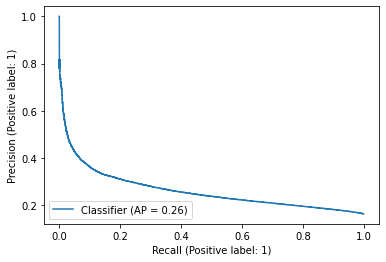

In [ ]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay, roc_auc_score
yq1_valid_preds = model.predict(Xq1_mm_valid,batch_size=40000,verbose=2)
PrecisionRecallDisplay.from_predictions(yq1_valid_np,yq1_valid_preds)

Create tensorflow tensor with downsampled dataset:

In [14]:
Xq1_mm_train_ds = Xq1_mm_train_ds.tocoo()
Xq1_mm_valid_ds = Xq1_mm_valid_ds.tocoo()

In [15]:
indices_train = [[u,v] for u,v in zip(Xq1_mm_train_ds.row,Xq1_mm_train_ds.col)]
indices_valid = [[u,v] for u,v in zip(Xq1_mm_valid_ds.row,Xq1_mm_valid_ds.col)]

In [16]:
values_train = Xq1_mm_train_ds.data
values_valid = Xq1_mm_valid_ds.data

In [25]:
dense_shape_train_ds = [Xq1_mm_train_ds.shape[0],Xq1_mm_train_ds.shape[1]]
dense_shape_valid_ds = [Xq1_mm_valid_ds.shape[0],Xq1_mm_valid_ds.shape[1]]

In [26]:
Xq1_mm_train_tf_ds = tf.sparse.SparseTensor(indices=indices_train,
                      values=values_train,
                      dense_shape=dense_shape_train_ds)

In [27]:
Xq1_mm_valid_tf_ds = tf.sparse.SparseTensor(indices=indices_valid,
                      values=values_valid,
                      dense_shape=dense_shape_valid_ds)

In [34]:
yq1_train_np_ds = np.array(yq1_train_ds)
yq1_valid_np_ds = np.array(yq1_valid)

The same architecture will be used:

In [35]:
history_ds = model.fit(Xq1_mm_train_tf_ds, yq1_train_np_ds, epochs=10, verbose=1, batch_size=40000,validation_data = (Xq1_mm_valid_ds,yq1_valid_np_ds))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 2233), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


34/34 [==============================] - 24s 492ms/step - loss: 0.6932 - binary_accuracy: 0.5008 - val_loss: 0.6922 - val_binary_accuracy: 0.8206
Epoch 2/10
34/34 [==============================] - 19s 475ms/step - loss: 0.6931 - binary_accuracy: 0.5003 - val_loss: 0.6932 - val_binary_accuracy: 0.4942
Epoch 3/10
34/34 [==============================] - 19s 482ms/step - loss: 0.6931 - binary_accuracy: 0.5012 - val_loss: 0.6919 - val_binary_accuracy: 0.5818
Epoch 4/10
34/34 [==============================] - 20s 482ms/step - loss: 0.6931 - binary_accuracy: 0.5023 - val_loss: 0.6929 - val_binary_accuracy: 0.4953
Epoch 5/10
34/34 [==============================] - 20s 484ms/step - loss: 0.6931 - binary_accuracy: 0.5018 - val_loss: 0.6944 - val_binary_accuracy: 0.4214
Epoch 6/10
34/34 [==============================] - 19s 480ms/step - loss: 0.6931 - binary_accuracy: 0.5024 - val_loss: 0.6902 - val_binary_accuracy: 0.7386
Epoch 7/10
34/34 [==============================] - 19s 478ms/step - 

Downsampling the dataset offered no advantage, in fact it substantially reduced the validation set accuracy to lower than the baseline (overfit to the downsampled training dataset very quickly)